# Tutorial : PyTorch Image Classifier with RedisAI 

**BentoML makes moving trained ML models to production easy:**

* Package models trained with **any ML framework** and reproduce them for model serving in production
* **Deploy anywhere** for online API serving or offline batch serving
* High-Performance API model server with *adaptive micro-batching* support
* Central hub for managing models and deployment process via Web UI and APIs
* Modular and flexible design making it *adaptable to your infrastrcuture*


BentoML is a framework for serving, managing, and deploying machine learning models. It is aiming to bridge the gap between Data Science and DevOps, and enable teams to deliver prediction services in a fast, repeatable, and scalable way.

[RedisAI](https://oss.redislabs.com/redisai/) is a popular model server for running ML models. RedisAI both maximizes computation throughput and reduces latency by adhering to the principle of data locality , as well as simplifies the deployment and serving of graphs by leveraging on Redis' production-proven infrastructure.


Before reading this example project, be sure to check out the [Getting started guide](https://github.com/bentoml/BentoML/blob/master/guides/quick-start/bentoml-quick-start-guide.ipynb) to learn about the basic concepts in BentoML.

This notebook was built based on the official pytorch tutorial https://pytorch.org/tutorials/beginner/blitz/cifar10_tutorial.html




In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
!pip install -r requirements.txt

In [3]:
import torch
import torchvision
import torchvision.transforms as transforms

# Training an image classifier

We will do the following steps in order:

* Load and normalizing the CIFAR10 training and test datasets using torchvision
* Define a Convolutional Neural Network
* Define a loss function
* Train the network on the training data
* Test the network on the test data
* Model Serving with BentoML


## 1 Loading and Normalizing CIFAR10

The output of torchvision datasets are PILImage images of range [0, 1]. We transform them to Tensors of normalized range [-1, 1].

In [4]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


Let us show some of the training images, for fun.

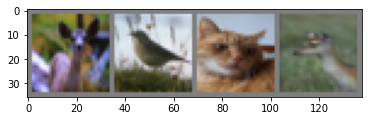

 deer  bird   cat  deer


In [5]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))

## 2 Define a Convolutional Neural Network

Copy the neural network from the Neural Networks section before and modify it to take 3-channel images (instead of 1-channel images as it was defined).

In [6]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
net = Net()

## 3 Define a Loss function and optimize

Let’s use a Classification Cross-Entropy loss and SGD with momentum.

In [7]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## 4 Train the network

This is when things start to get interesting. We simply have to loop over our data iterator, and feed the inputs to the network and optimize.

In [8]:
for epoch in range(10):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 2000 == 1999:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 2000))
            running_loss = 0.0

print('Finished Training')

/home/longld/anaconda3/envs/redisai/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[1,  2000] loss: 2.290
[1,  4000] loss: 1.955
[1,  6000] loss: 1.718
[1,  8000] loss: 1.604
[1, 10000] loss: 1.531
[1, 12000] loss: 1.477
[2,  2000] loss: 1.408
[2,  4000] loss: 1.391
[2,  6000] loss: 1.350
[2,  8000] loss: 1.326
[2, 10000] loss: 1.319
[2, 12000] loss: 1.311
[3,  2000] loss: 1.229
[3,  4000] loss: 1.233
[3,  6000] loss: 1.210
[3,  8000] loss: 1.212
[3, 10000] loss: 1.213
[3, 12000] loss: 1.186
[4,  2000] loss: 1.125
[4,  4000] loss: 1.123
[4,  6000] loss: 1.123
[4,  8000] loss: 1.102
[4, 10000] loss: 1.117
[4, 12000] loss: 1.127
[5,  2000] loss: 1.030
[5,  4000] loss: 1.028
[5,  6000] loss: 1.044
[5,  8000] loss: 1.055
[5, 10000] loss: 1.086
[5, 12000] loss: 1.058
[6,  2000] loss: 0.982
[6,  4000] loss: 0.990
[6,  6000] loss: 0.996
[6,  8000] loss: 0.995
[6, 10000] loss: 1.027
[6, 12000] loss: 1.003
[7,  2000] loss: 0.909
[7,  4000] loss: 0.950
[7,  6000] loss: 0.944
[7,  8000] loss: 0.960
[7, 10000] loss: 0.960
[7, 12000] loss: 0.996
[8,  2000] loss: 0.875
[8,  4000] 

## 5 Test the network on the test data

We have trained the network for 2 passes over the training dataset. But we need to check if the network has learnt anything at all.

We will check this by predicting the class label that the neural network outputs, and checking it against the ground-truth. If the prediction is correct, we add the sample to the list of correct predictions.

Okay, first step. Let us display an image from the test set to get familiar.

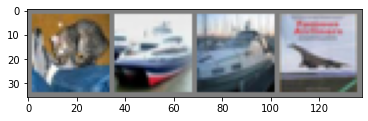

GroundTruth:    cat  ship  ship plane


In [9]:
dataiter = iter(testloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(4)))

Let us look at how the network performs on the whole dataset.

In [10]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 62 %


# 6 Model Serving with BentoML

## 6.1 Custom Artifact with Redisai

If you are new to RedisAI and trying it out for the first time, you might not know the setup already (although it's quite easy to setup a local RedisAI instance). In that's the case, you need pull the latest docker image of RedisAI (yes, you need docker installed in your machine for this to work), run it on the default port, deploy the model you specified.

Run docker redisai if cpu:
```
docker run -dp 6379:6379 -it --rm  redislabs/redisai:edge-cpu-bionic
```
and if gpu:
```
docker run -p 6379:6379 --gpus all -it --rm redislabs/redisai:edge-gpu-bionic
```

See all tag image rediasai [here](https://hub.docker.com/r/redislabs/redisai/tags?page=1&ordering=last_updated). 

PS: It's IMPORTANT to note that this API leaves the docker container running. You would need to manually stop the container once you are done with experimentation. Also, remember that if you trying to run this API twice without killing the first container, it throws an error saying the port is already in use.

Here I will use redisai cpu.


In [11]:
!docker run -dp 6379:6379 -it --rm  redislabs/redisai:edge-cpu-bionic

8158f72bbbdd788770ee1d9f1fa97d58d63bf6f1b9e786e11c47c07ba68dc566
docker: Error response from daemon: driver failed programming external connectivity on endpoint gracious_banzai (1c68f52f3955f8107c15354fd2a76c00250c6a00fd1e17be3bd4da153b1fd7f0): Bind for 0.0.0.0:6379 failed: port is already allocated.


The following code creates a subclass from the BentoServiceArtifact. It implements how to save and load the model.

In the initialization of the artifact, we have the following parameters:

- backend : the backend used by the model as a String
- device : the device used to execute the model as a String
- inputs : array reply with one or more names of the model's input nodes (applicable only for TensorFlow models)
- outputs : array reply with one or more names of the model's output nodes (applicable only for TensorFlow models)

This code was built based on A plugin that integrates RedisAI with MLflow pipeline https://github.com/RedisAI/mlflow-redisai.




In [12]:
%%writefile redisai_artifact.py
import os
from bentoml.exceptions import (
    BentoMLException,
    InvalidArgument,
    MissingDependencyException,
)

from bentoml.service.artifacts import BentoServiceArtifact
import redisai as rai
import logging

logger = logging.getLogger(__name__)


# Connection parameters
class Config(dict):
    def __init__(self):
        super().__init__()
        self['host'] = 'localhost'
        self['port'] = 6379
        self['username'] = None
        self['password'] = None
        self['db'] = 0


SUPPORTED_BACKEND = ["torch", "tf", "onnx"]
file_extension = {
    'torch': '.pt',
    'tf'   : '.pb',
    'onnx' : '.onnx'}


class RedisaiArtifact(BentoServiceArtifact):
    def __init__(self, name, backend='torch', inputs=None, outputs=None, device='cpu'):
        super(RedisaiArtifact, self).__init__(name)
        if backend not in SUPPORTED_BACKEND:
            raise BentoMLException(
                f'"{backend}" runtime is currently not supported for RedisaiArtifact'
            )
        server_config = Config()
        # Connecting to a RedisAI 
        self.con = rai.Client(**server_config)
        self._input = inputs
        self._output = outputs
        self._backend = backend
        self._device = device
        self._model = None

    def pack(self, model):
        if self._backend == 'torch':
            try:
                import torch
            except ImportError:
                raise MissingDependencyException(
                    "torch package is required to use RedisaiArtifact"
                )

            if not isinstance(model, torch.nn.Module):
                raise InvalidArgument(
                    "RedisaiArtifact can only pack type 'torch.jit.ScriptModule'"
                )

        elif self._backend == 'tf':
            try:
                import tensorflow as tf

            except ImportError:
                raise MissingDependencyException(
                    "Tensorflow package is required to use RedisaiArtifact."
                )

        elif self._backend == 'onnx':
            try:
                import onnx

                if not isinstance(model, onnx.ModelProto):
                    raise InvalidArgument(
                        "onnx.ModelProto model file path is required to "
                        "pack an RedisaiArtifact"
                    )

            except ImportError:
                raise InvalidArgument(
                    "ONNX package is required to use RedisaiArtifact."
                )

        self._model = model

        return self

    def get(self):
        return self.con

    def save(self, dst):

        if self._backend == 'torch':
            import torch

            if self._model.training is True:
                logger.warn('Graph is in training mode. Converting to evaluation mode')

                self._model.eval()

            torch.jit.save(self._model, self._file_path(dst))

        elif self._backend == 'tf':
            import tensorflow as tf

            TF2 = tf.__version__.startswith('2')
            if TF2:
                tf.io.write_graph(graph_or_graph_def=self._model.graph,
                                  logdir=dst,
                                  name=self.name + file_extension[self._backend],
                                  as_text=False)
            else:
                tf.compat.v1.disable_eager_execution()
                tf.train.write_graph(self._model, dst, self.name + file_extension[self._backend], as_text=False)

        elif self._backend == 'onnx':
            import onnx
            onnx.save_model(self._model, self._file_path(dst))

        return self

    def load(self, path):
        with open(self._file_path(path), 'rb') as f:
            model_redisai = f.read()

        self.con.modelstore(self.name, self._backend, self._device, model_redisai, inputs=self._input,
                            outputs=self._output)


    def _file_path(self, base_path):
        return os.path.join(base_path, self.name + file_extension[self._backend])


Overwriting redisai_artifact.py


## 6.2 Define and save BentoService with the custom Artifact

In [13]:
%%writefile pytorch_image_classifier.py

from typing import List, BinaryIO

from PIL import Image
import torch
from torch.autograd import Variable
from torchvision import transforms
import numpy as np 
import bentoml
from bentoml import BentoService, env, api, artifacts
from redisai_artifact import RedisaiArtifact
from bentoml.adapters import FileInput


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

@env(pip_packages=['torch', 'numpy', 'torchvision', 'redisai'])
@artifacts([RedisaiArtifact('net')])
class PytorchImageClassifier(BentoService):

    @bentoml.utils.cached_property
    def transform(self):
        return transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
        ])
    
    @api(input=FileInput(), batch=True)
    def predict(self, file_streams: List[BinaryIO]) -> List[str]:
        input_datas = []
        for fs in file_streams:
            img = Image.open(fs).resize((32, 32))
            input_datas.append(self.transform(img))
        
        # Get cline redisai
        con = self.artifacts.net
        con.tensorset('ips', Variable(torch.stack(input_datas)).cpu().detach().numpy(), dtype='float')

        con.modelrun('net', inputs=['ips'], outputs=['outs'])
        outputs = con.tensorget('outs')
        output_classes = outputs.argmax(axis=1)

        return [classes[output_class] for output_class in output_classes]   

Overwriting pytorch_image_classifier.py


Because RedisAI currently supports TorchScript, we convert PyTorch into to TorchScript as follows:

In [14]:
batch = torch.randn((4, 3, 32, 32))
net.eval()
net = torch.jit.trace(net, (batch))

Now you can instantiate a BentoService defined above with the trained model, and save the entire BentoService to a file archive:

In [15]:
# 1) import the custom BentoService defined above
from pytorch_image_classifier import PytorchImageClassifier

# 2) `pack` it with required artifacts
bento_svc = PytorchImageClassifier()
bento_svc.pack('net', net)

# 3) save your BentoSerivce to file archive
saved_path = bento_svc.save()
print(saved_path)

[2021-09-28 09:47:02,356] INFO - BentoService bundle 'PytorchImageClassifier:20210928094659_078F37' saved to: /home/longld/bentoml/repository/PytorchImageClassifier/20210928094659_078F37
/home/longld/bentoml/repository/PytorchImageClassifier/20210928094659_078F37


## REST API Model Serving (for debug only)


To start a REST API model server with the BentoService saved above, use the bentoml serve command:

In [ ]:
!bentoml serve PytorchImageClassifier:latest --enable-microbatch

[2021-09-28 09:47:02,759] WARNING - Option --enable-microbatch/--disable-microbatch has been deprecated in the current release. The micro-batching option has become the default. Consider using --mb-max-batching=1 to simulate the effect of --disable-microbatch
[2021-09-28 09:47:03,162] INFO - Getting latest version PytorchImageClassifier:20210928094659_078F37
[2021-09-28 09:47:03,299] INFO - Starting BentoML API proxy in development mode..
[2021-09-28 09:47:03,300] INFO - Starting BentoML API server in development mode..
[2021-09-28 09:47:03,386] INFO - Micro batch enabled for API `predict` max-latency: 20000 max-batch-size 4000
[2021-09-28 09:47:03,386] INFO - Your system nofile limit is 4096, which means each instance of microbatch service is able to hold this number of connections at same time. You can increase the number of file descriptors for the server process, or launch more microbatch instances to accept more concurrent connection.
======== Running on http://0.0.0.0:5000 ======

Open a terminal and go to the directory of the current notebook, then run the following command to evaluate.

```bash
curl -X POST "http://127.0.0.1:5000/predict" -H "Content-Type: image/*" --data-binary "@bird.jpg"
```

alternatively:
```bash
curl -X POST "http://127.0.0.1:5000/predict" -F image=@bird.png
```


Go visit http://127.0.0.1:5000/ from your browser, click `/predict` -> `Try it out` -> `Choose File` -> `Execute` to sumbit an image from your computer

## Launch inference job from CLI

BentoML cli supports loading and running a packaged model from CLI. With the DataframeInput adapter, the CLI command supports reading input Dataframe data from CLI argument or local csv or json files:

In [ ]:
!bentoml run PytorchImageClassifier:latest predict  --input-file bird.jpg

# Deployment Options

If you are at a small team with limited engineering or DevOps resources, try out automated deployment with BentoML CLI, currently supporting AWS Lambda, AWS SageMaker, and Azure Functions:
- [AWS Lambda Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_lambda.html)
- [AWS SageMaker Deployment Guide](https://docs.bentoml.org/en/latest/deployment/aws_sagemaker.html)
- [Azure Functions Deployment Guide](https://docs.bentoml.org/en/latest/deployment/azure_functions.html)

If the cloud platform you are working with is not on the list above, try out these step-by-step guide on manually deploying BentoML packaged model to cloud platforms:
- [AWS ECS Deployment](https://docs.bentoml.org/en/latest/deployment/aws_ecs.html)
- [Google Cloud Run Deployment](https://docs.bentoml.org/en/latest/deployment/google_cloud_run.html)
- [Azure container instance Deployment](https://docs.bentoml.org/en/latest/deployment/azure_container_instance.html)
- [Heroku Deployment](https://docs.bentoml.org/en/latest/deployment/heroku.html)

Lastly, if you have a DevOps or ML Engineering team who's operating a Kubernetes or OpenShift cluster, use the following guides as references for implementating your deployment strategy:
- [Kubernetes Deployment](https://docs.bentoml.org/en/latest/deployment/kubernetes.html)
- [Knative Deployment](https://docs.bentoml.org/en/latest/deployment/knative.html)
- [Kubeflow Deployment](https://docs.bentoml.org/en/latest/deployment/kubeflow.html)
- [KFServing Deployment](https://docs.bentoml.org/en/latest/deployment/kfserving.html)
- [Clipper.ai Deployment Guide](https://docs.bentoml.org/en/latest/deployment/clipper.html)